Seed set to 22122020
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Copying sres.fourier_coefficient_embedding.weight
Copying sres.fourier_coefficient_embedding.bias
Copying sres.predictor_amp.weight
Copying sres.predictor_amp.bias
Copying sres.predictor_phase.weight
Copying sres.predictor_phase.bias


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Copying sres.fourier_coefficient_embedding.weight
Copying sres.fourier_coefficient_embedding.bias
Copying sres.predictor_amp.weight
Copying sres.predictor_amp.bias
Copying sres.predictor_phase.weight
Copying sres.predictor_phase.bias


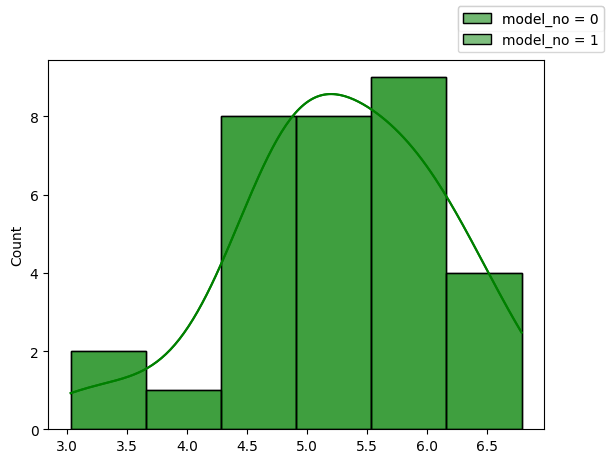

In [14]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.transformers.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch

import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy
seed_everything(22122020)
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data(subset_flag=False)
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 5,model_path = '')
fig = plt.figure()
psnr_dict = {}
trained_model_path = ['/home/aman.kukde/Projects/FourierImageTransformer/model-5.ckpt','/home/aman.kukde/Projects/FourierImageTransformer/models_saved/model_main_07032024/epoch=943-step=944.ckpt']
for model_no,path in enumerate(trained_model_path):
    model.load_test_model(path)
    # model.cuda()
    tokeniser_weights = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/model.ckpt')['state_dict']
    for key in list(tokeniser_weights.keys()):
        if '.encoder' in key:
            del tokeniser_weights[key]

    def load_partial_state_dict(model, state_dict):
        own_state = model.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                print(f'Copying {name}')
                if own_state[name].size() == param.size():
                    own_state[name].copy_(param)
                    own_state[name].requires_grad = False
                    own_state[name].training = False
            # else:
            #     print(f'Layer {name} not found in current model')
        model.load_state_dict(tokeniser_weights, strict=False)
        return model

    model = load_partial_state_dict(model, tokeniser_weights)

    trainer = Trainer(max_epochs=100, 
                    #gpus=1, # set to 0 if you want to run on CPU
                    callbacks=ModelCheckpoint(
                                                dirpath=None,
                                                save_top_k=1,
                                                verbose=False,
                                                save_last=True,
                                                monitor='Validation/avg_val_loss',
                                                mode='min'
                                            ), 
                    deterministic=True)
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break
    # for fc, (mag_min, mag_max) in dm.train_dataloader():
    #     break
    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    x_fc = fc[:, flatten_order][:, :96]
    pred = model.sres.forward_i(x_fc,96)
    # pred[:,96:] = (pred[:,96:] - pred[:,96:].min()) / (pred[:,96:].max() - pred[:,96:].min())
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)

                        
    lowres = torch.zeros_like(pred)
    # lowres += fc.min()
    lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)
    psnr_dict[str(model_no)] = pred_psnr.cpu().detach() - lowres_psnr.cpu().detach()
    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True, label = "model_no = "+str(model_no))
    fig.legend()
    plt.savefig('psnr_diff.png')
    # plt.close()
    

In [15]:
psnr_dict['0'] - psnr_dict['1']

tensor([ 1.5831e-04,  0.0000e+00,  3.4332e-05,  1.3351e-05, -1.5259e-05,
         3.2425e-05,  2.5177e-04,  7.6294e-06,  0.0000e+00, -1.3924e-04,
         0.0000e+00, -1.3351e-05,  1.0490e-04,  1.4496e-04, -1.3161e-04,
        -1.5259e-05, -3.2425e-04, -3.4332e-05, -1.7166e-05, -2.6703e-05,
         7.6294e-06, -3.8147e-06,  1.1444e-04,  5.7220e-06, -2.2507e-04,
         1.1444e-05, -1.3161e-04,  2.4796e-05,  5.5313e-05, -2.7084e-04,
         8.7738e-05, -7.6294e-06])

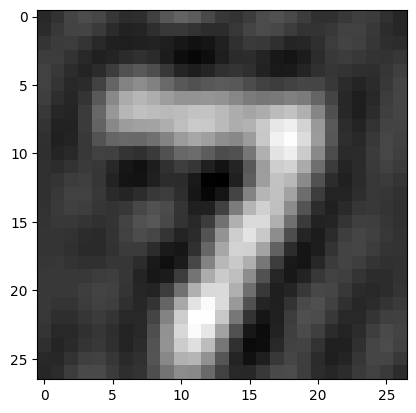

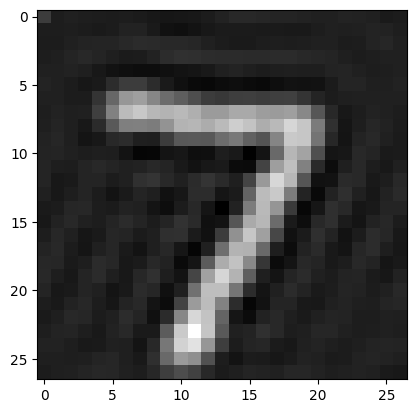

In [3]:
plt.imshow(lowres_img[0].cpu(), cmap='gray')
plt.show()
plt.imshow(pred_img[0].cpu(), cmap='gray')

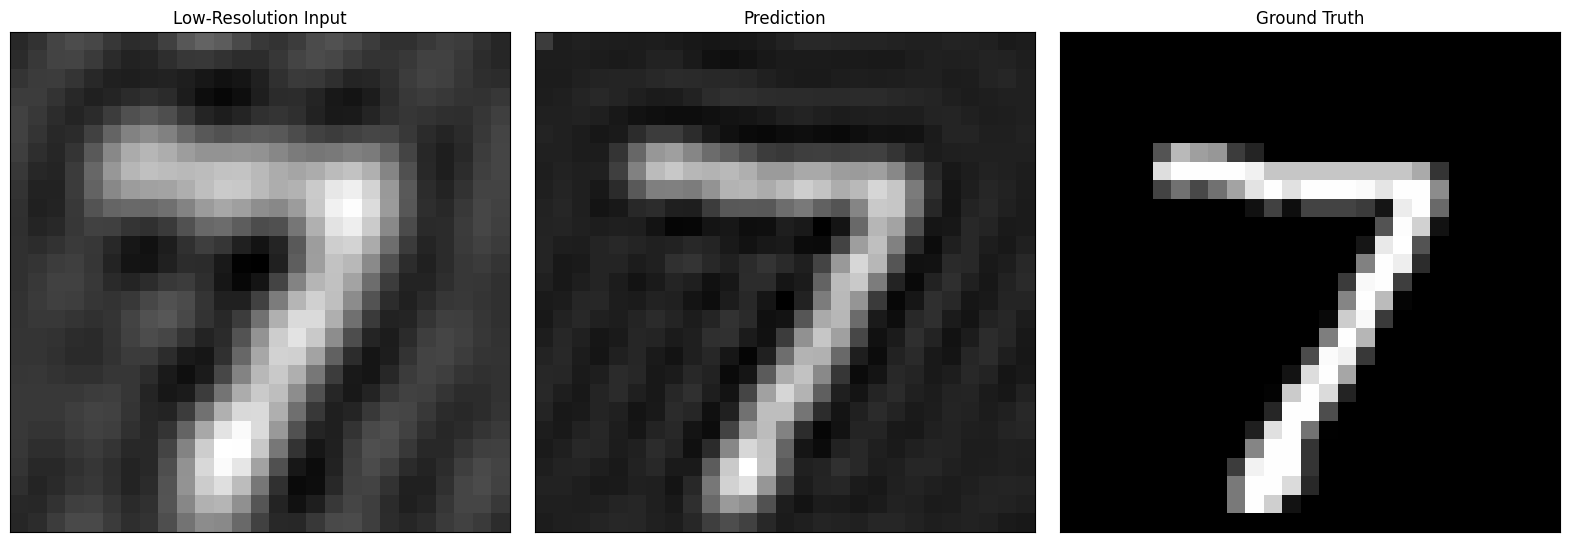

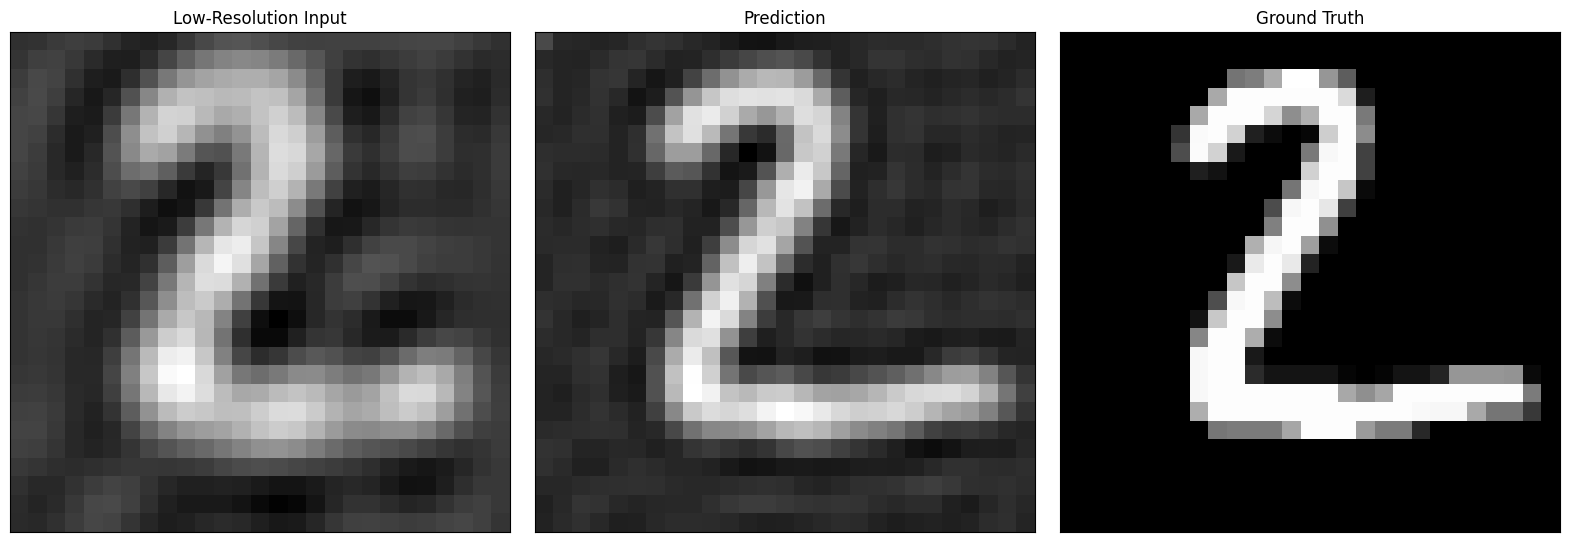

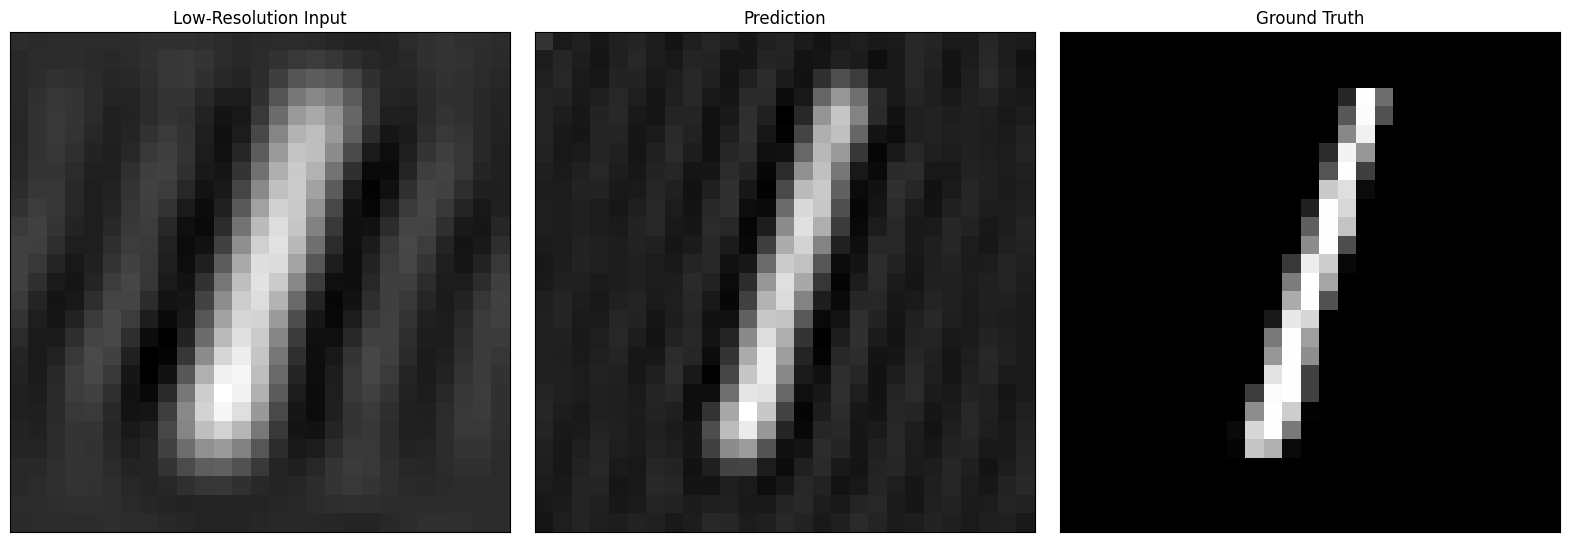

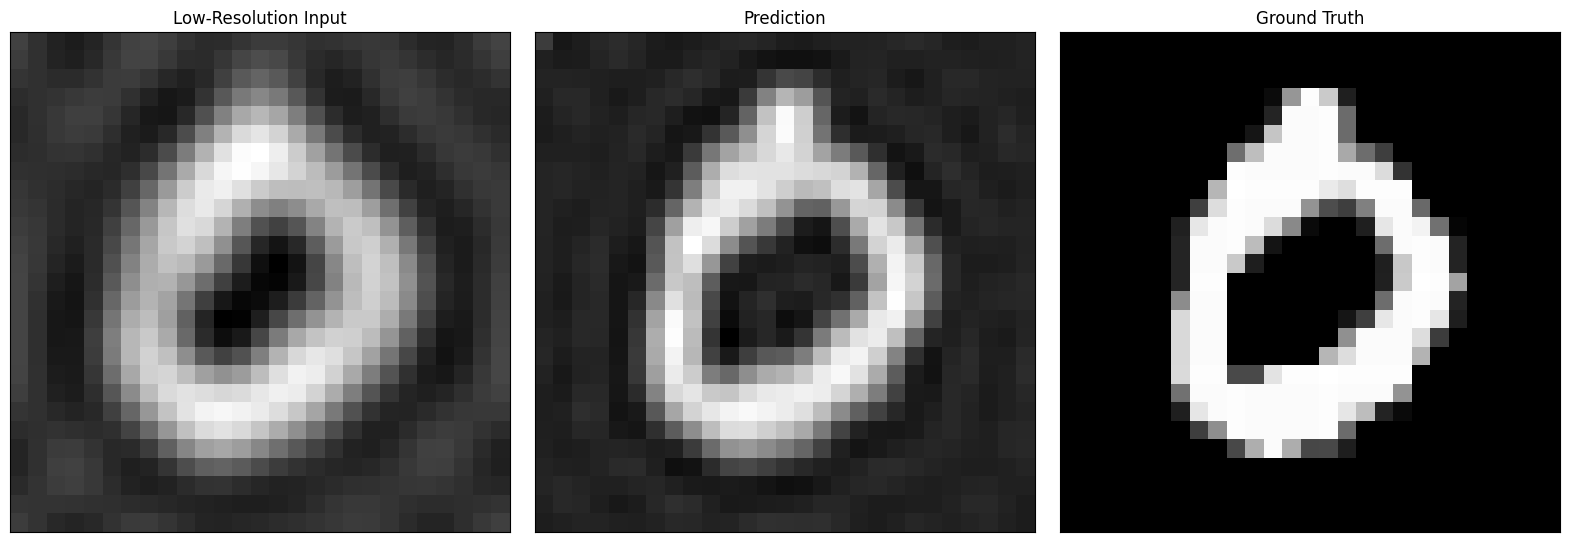

In [4]:
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()
for sample in range(4):
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

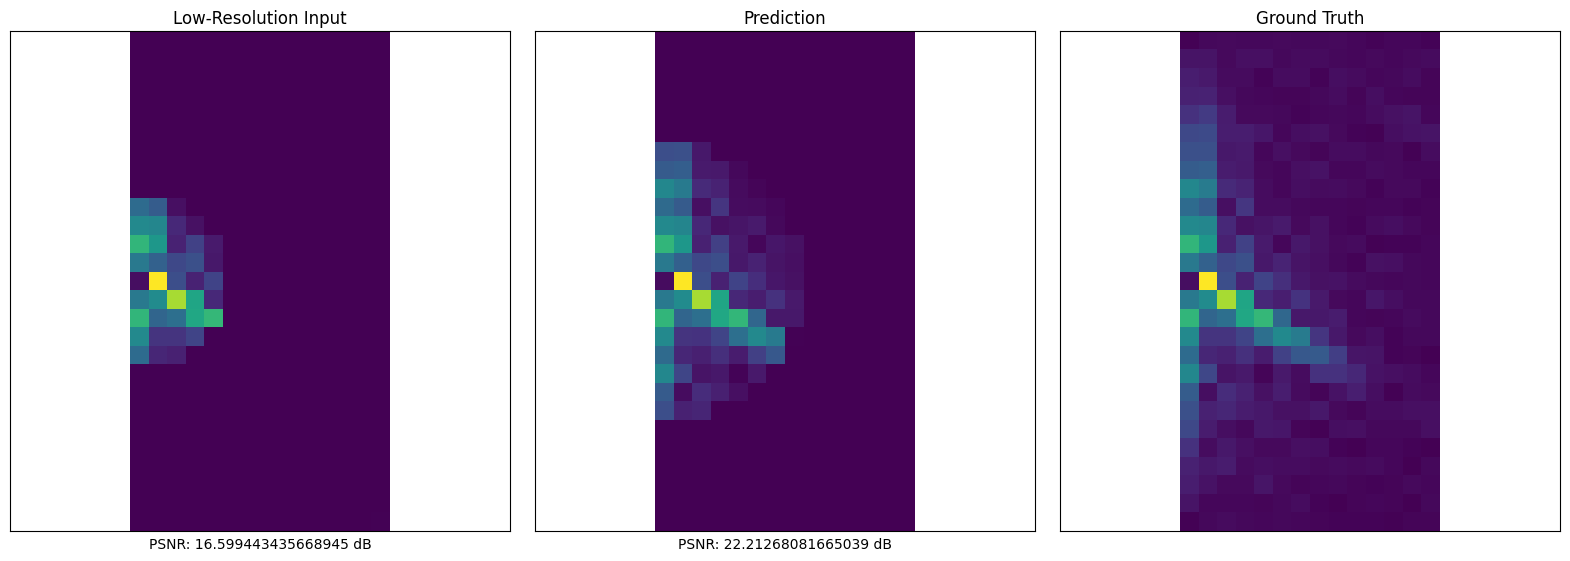

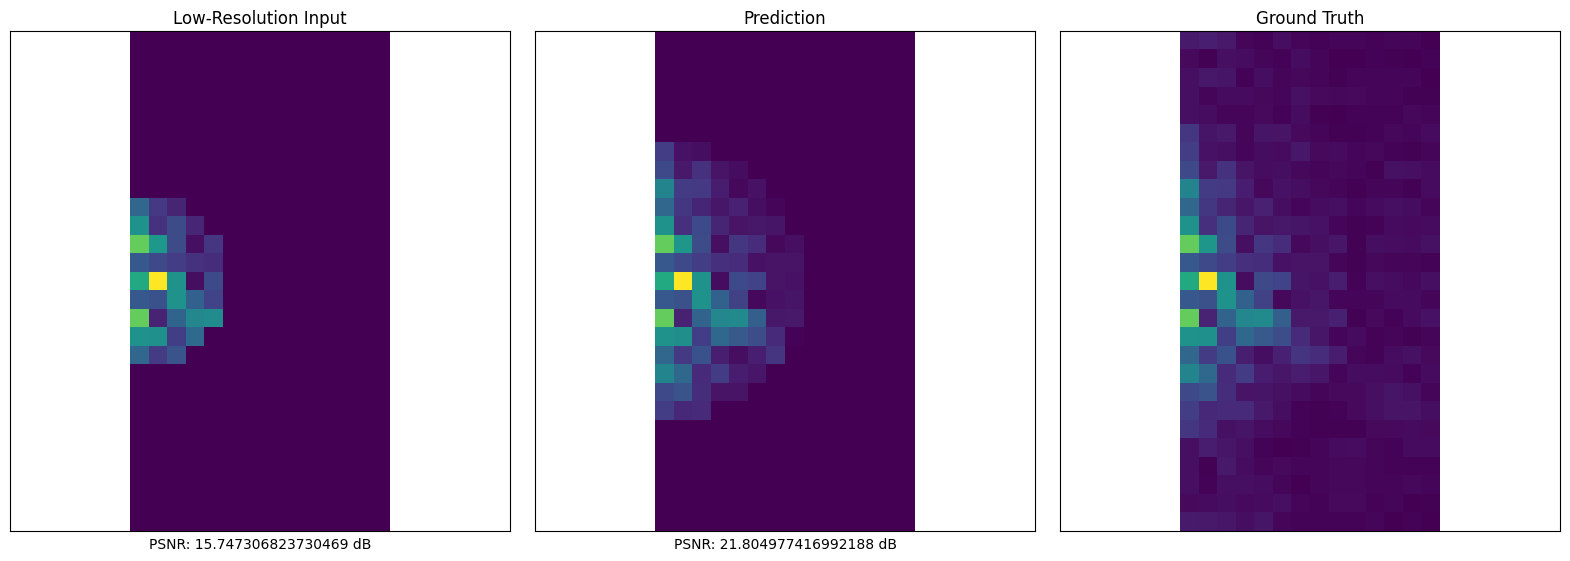

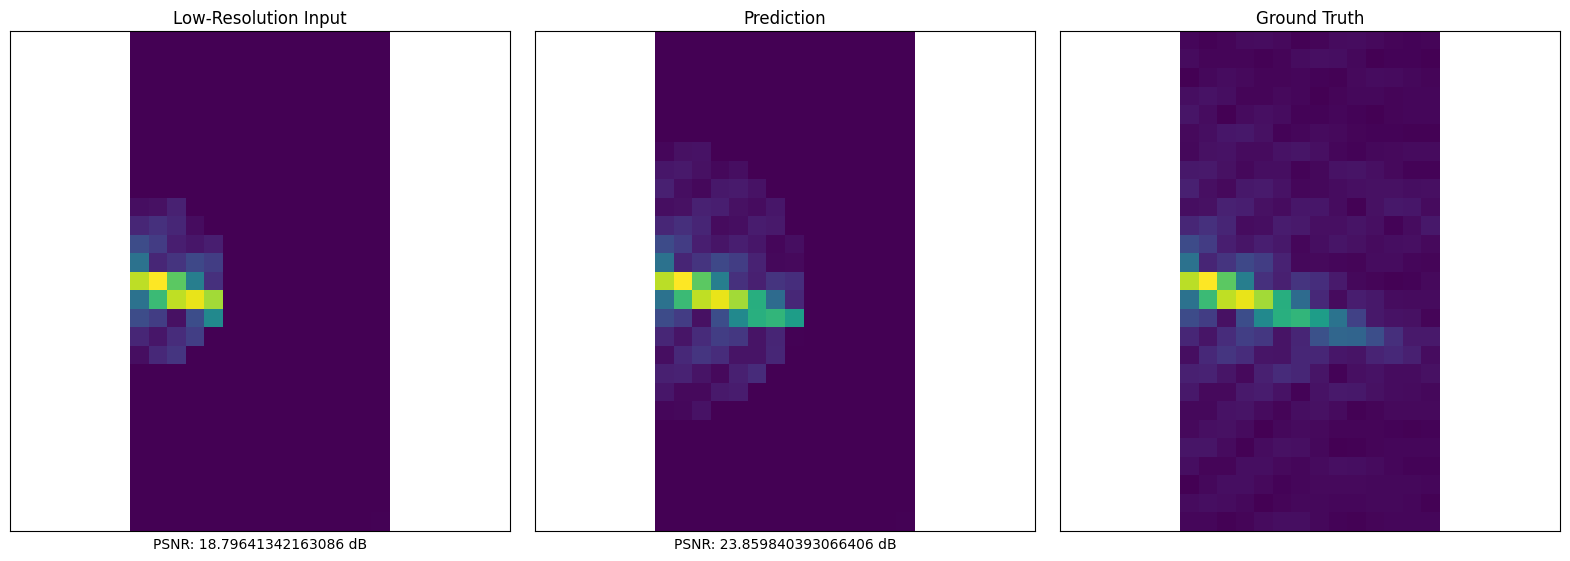

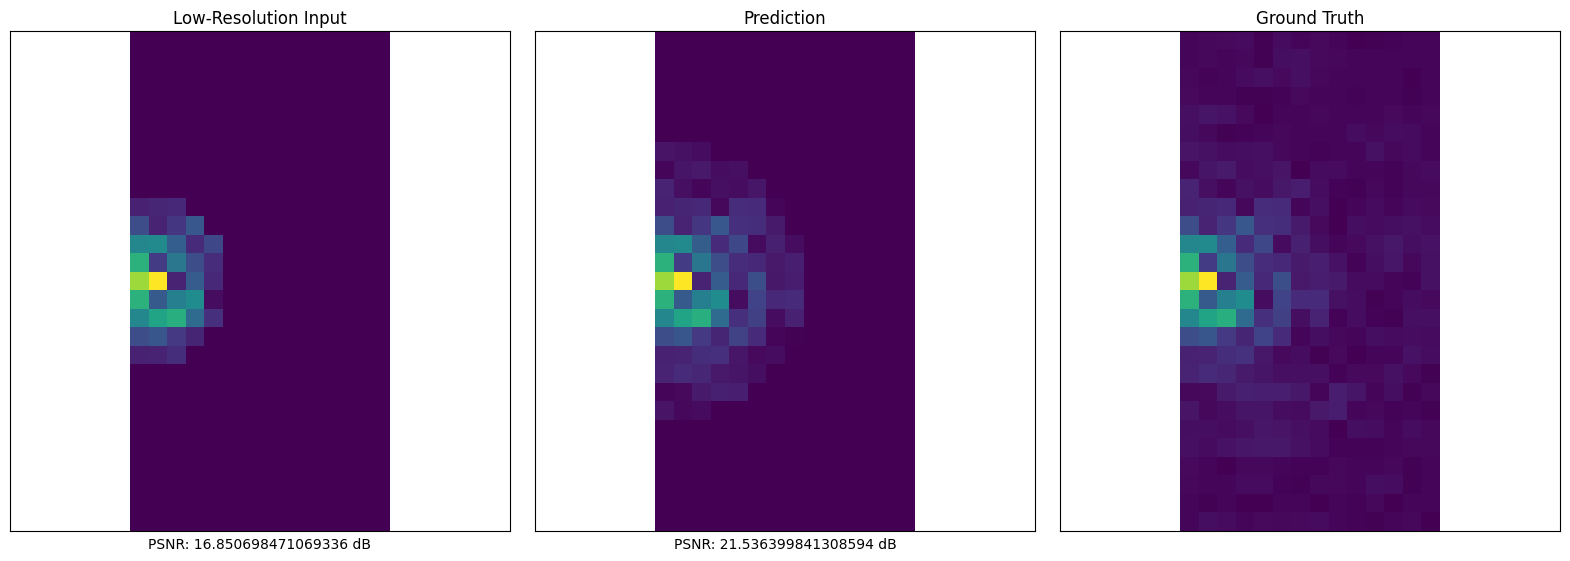

In [5]:
from sklearn.random_projection import sample_without_replacement


diff =[]
for i in range(4):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)

<Axes: >

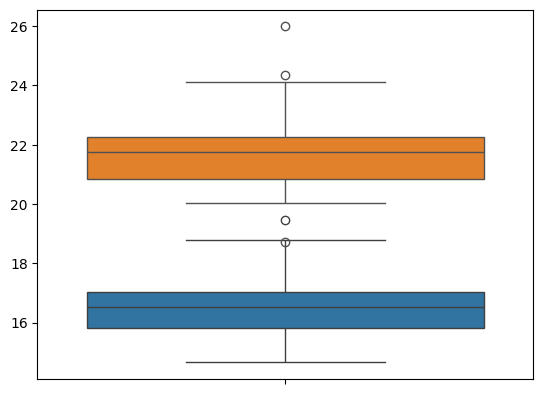

In [6]:
sns.boxplot(lowres_psnr.cpu().detach().numpy())
sns.boxplot(pred_psnr.cpu().detach().numpy())